In [1]:
%%capture
!pip install datasets
!pip install gensim
!pip install sentence-transformers
!pip install contractions
!pip install nltk
!pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from torch.utils.data import DataLoader
import torch
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
from sentence_transformers import util
from transformers import RobertaTokenizer, RobertaModel
from sentence_transformers import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator
from sentence_transformers import InputExample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.plotting import plot_confusion_matrix
from gensim.models import word2vec
from transformers import AutoTokenizer
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import xgboost as xgb
import string
import joblib
import re
import os
import shutil
import math




/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from datasets import load_dataset
import pandas as pd


# Load the Quora dataset from Hugging Face
quora_dataset = load_dataset('quora')

# Convert the dataset to a pandas DataFrame
dframe = quora_dataset['train'].to_pandas()


dframe.head()



Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

,questions,is_duplicate
0,"{'id': [1, 2], 'text': ['What is the step by s...",False
1,"{'id': [3, 4], 'text': ['What is the story of ...",False
2,"{'id': [5, 6], 'text': ['How can I increase th...",False
3,"{'id': [7, 8], 'text': ['Why am I mentally ver...",False
4,"{'id': [9, 10], 'text': ['Which one dissolve i...",False


In [4]:
#splitting of data first
df_train,df_test = train_test_split(dframe,
                                   test_size=0.3,
                                   stratify=dframe['is_duplicate'],
                                   random_state=42)

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

print("Training data shape:",df_train.shape)
print("Test data shape:",df_test.shape)

Training data shape: (283003, 2)
Test data shape: (121287, 2)


In [5]:
df_train

,questions,is_duplicate
0,"{'id': [11069, 240809], 'text': ['How do I gai...",True
1,"{'id': [6787, 6788], 'text': ['What is unusual...",False
2,"{'id': [170658, 170659], 'text': ['How can I m...",False
3,"{'id': [336441, 336442], 'text': ['How much ca...",True
4,"{'id': [51302, 226085], 'text': ['How can I tr...",False
...,...,...
282998,"{'id': [216648, 74022], 'text': ['What is best...",True
282999,"{'id': [8461, 35301], 'text': ['How do I impro...",True
283000,"{'id': [435756, 435757], 'text': ['Would you b...",False
283001,"{'id': [364945, 364946], 'text': ['What is the...",False


In [6]:
df_test

,questions,is_duplicate
0,"{'id': [398338, 511809], 'text': ['Was it appr...",True
1,"{'id': [120456, 473749], 'text': ['I have forg...",False
2,"{'id': [326090, 326091], 'text': ['What book d...",False
3,"{'id': [341728, 341729], 'text': ['How do you ...",True
4,"{'id': [314306, 442046], 'text': ['I've seen b...",False
...,...,...
121282,"{'id': [354415, 354416], 'text': ['What was th...",True
121283,"{'id': [303892, 171844], 'text': ['Is there an...",False
121284,"{'id': [185806, 67162], 'text': ['What is the ...",False
121285,"{'id': [190839, 190840], 'text': ['How can I g...",False


In [23]:
#spliting the questions in train dataset



# Sample data
data = {
    'questions': [
        {"id": [1, 2], "text": ["What is the step by step guide to invest in share market in india?", "What is the step by step guide to invest in share market?"]},
        {"id": [3, 4], "text": ["What is the story of Kohinoor (Koh-i-Noor) Diamond?", "What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?"]}
    ],
    'is_duplicate': [False, False]
}

# Create DataFrame
df = pd.DataFrame(df_train)

# Empty lists to store split data
id_list_question1 = []
text_list_question1 = []
id_list_question2 = []
text_list_question2 = []
is_duplicate_list = []

# Iterate through rows
for index, row in df.iterrows():
    ids = row['questions']['id']
    texts = row['questions']['text']
    is_duplicate = row['is_duplicate']

    if len(ids) == 2:  # If there's a pair of questions
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(ids[1])
        text_list_question2.append(texts[1])
    else:  # If there's only one question
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(None)
        text_list_question2.append(None)

    is_duplicate_list.append(is_duplicate)

# Create new DataFrame
new_df_train = pd.DataFrame({
                       'text_question1': text_list_question1,

                       'text_question2': text_list_question2,
                       'is_duplicate': is_duplicate_list})

print(new_df_train)



                                           text_question1  \
0       How do I gain healthy weight without eating junk?   
1       What is unusual or different about the food an...   
2       How can I make music player with sensor in and...   
3                  How much can you charge for a website?   
4                     How can I treat a swollen clitoris?   
...                                                   ...   
282998  What is best way for preparing civil services ...   
282999              How do I improve my English speaking?   
283000  Would you beat a man up if he talked and flirt...   
283001  What is the difference between media and liter...   
283002               What is corporate events management?   

                                           text_question2  is_duplicate  
0       What are the healthy ways of gaining weight an...          True  
1       What is unusual or different about the food an...         False  
2                How can I make music player 

In [24]:
#splitting the data in test dataset

df = pd.DataFrame(df_test)

# Empty lists to store split data
id_list_question1 = []
text_list_question1 = []
id_list_question2 = []
text_list_question2 = []
is_duplicate_list = []

# Iterate through rows
for index, row in df.iterrows():
    ids = row['questions']['id']
    texts = row['questions']['text']
    is_duplicate = row['is_duplicate']

    if len(ids) == 2:  # If there's a pair of questions
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(ids[1])
        text_list_question2.append(texts[1])
    else:  # If there's only one question
        id_list_question1.append(ids[0])
        text_list_question1.append(texts[0])
        id_list_question2.append(None)
        text_list_question2.append(None)

    is_duplicate_list.append(is_duplicate)

# Create new DataFrame
new_df_test = pd.DataFrame({
                       'text_question1': text_list_question1,

                       'text_question2': text_list_question2,
                       'is_duplicate': is_duplicate_list})

print(new_df_test)

                                           text_question1  \
0       Was it appropriate for Meryl Streep to use her...   
1       I have forgot the screen unlock PIN code of my...   
2                          What book do you want to read?   
3           How do you know what is true and what is not?   
4       I've seen bald men treated equally as others i...   
...                                                   ...   
121282  What was the real cause of air pollution in De...   
121283        Is there any proof we live in a simulation?   
121284           What is the difference between ば and たら?   
121285                          How can I go Switzerland?   
121286           Why is there no Siri in OS X El Capitan?   

                                           text_question2  is_duplicate  
0       Should Meryl Streep be using her position to a...          True  
1                            How do I unlock my HTC 2200?         False  
2                  How do you choose what boo

Exploratory Data Analysis
Exploratory data analysis is the process of analyzing and summarizing a dataset to gain insights and understanding of its main characteristics. It involves techniques such as data visualization, summary statistics, and data cleaning to discover patterns and relationships within the data. EDA is a crucial step in the data analysis process as it helps to inform subsequent modeling and analysis decisions.



<Axes: >

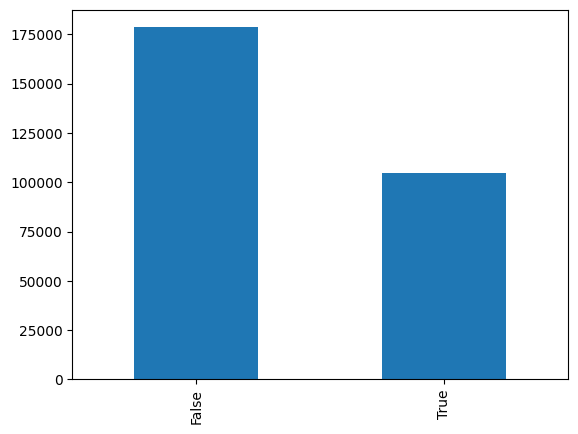

In [25]:
new_df_train['is_duplicate'].value_counts().plot(kind='bar')

<Axes: >

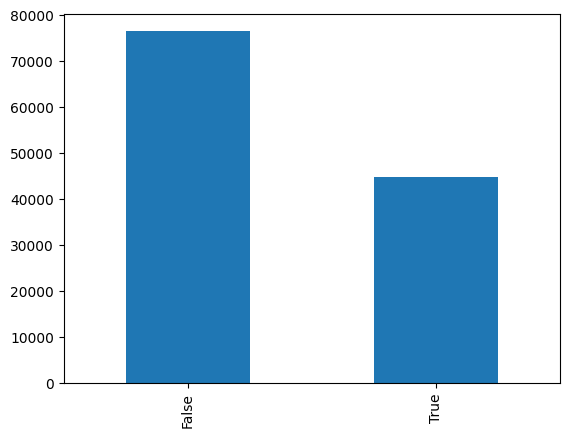

In [26]:
new_df_test['is_duplicate'].value_counts().plot(kind='bar')
#unbalanced data -lit review

In [27]:
# Repeated question in train dataset
qid = pd.Series(new_df_train['text_question1'].tolist() + new_df_train['text_question2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])


Number of unique questions 403284
Number of questions getting repeated 73299


In [28]:
# Repeated question in test dataset
qid = pd.Series(new_df_test['text_question1'].tolist() + new_df_test['text_question2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 196769
Number of questions getting repeated 24901


Let us now construct a few features like:

freq_qid1 = Frequency of qid1's
freq_qid2 = Frequency of qid2's
q1len = Length of q1
q2len = Length of q2
q1_n_words = Number of words in Question 1
q2_n_words = Number of words in Question 2
word_Common = (Number of common unique words in Question 1 and Question 2)
word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
word_share = (word_common)/(word_Total)
freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [29]:
#Feature engineering
df = new_df_train.sample(10000)
df['freq_qid1'] = df.groupby('text_question1')['text_question2'].transform('count')
df['freq_qid2'] = df.groupby('text_question2')['text_question2'].transform('count')
df['q1len'] = df['text_question1'].str.len()
df['q2len'] = df['text_question2'].str.len()
df['q1_words'] = df['text_question1'].apply(lambda x: len(x.split(" ")))
df['q2_words'] = df['text_question2'].apply(lambda x: len(x.split(" ")))

def normalized_word_count(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * (len(w1 & w2))
df['word_common'] = df.apply(normalized_word_count, axis = 1)


def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['text_question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['text_question2'].split(" ")))
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])



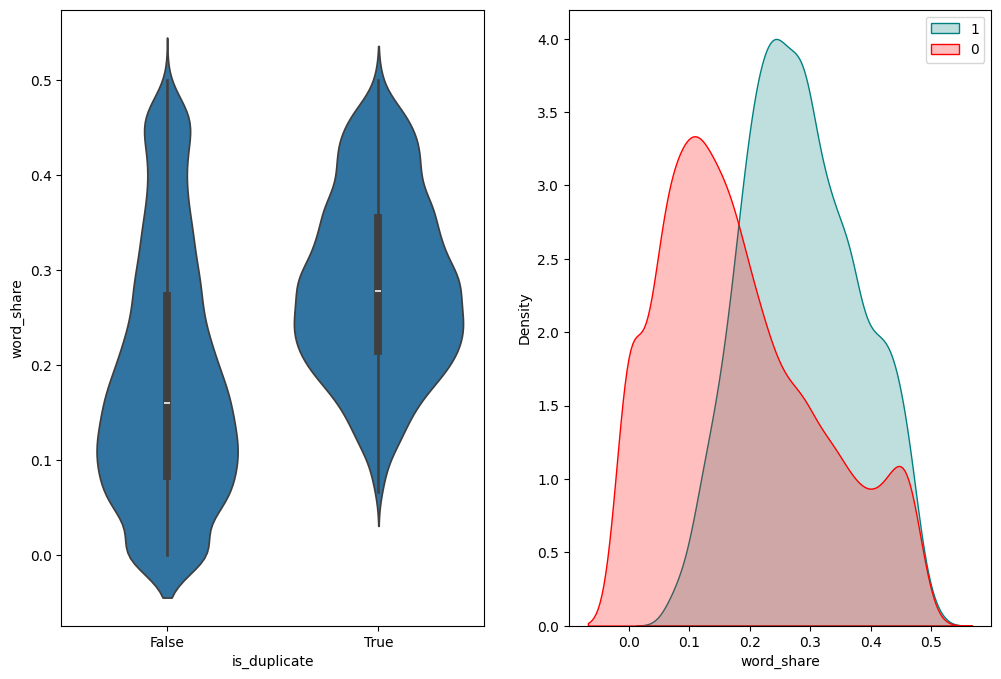

In [30]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_share", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_share'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_share'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

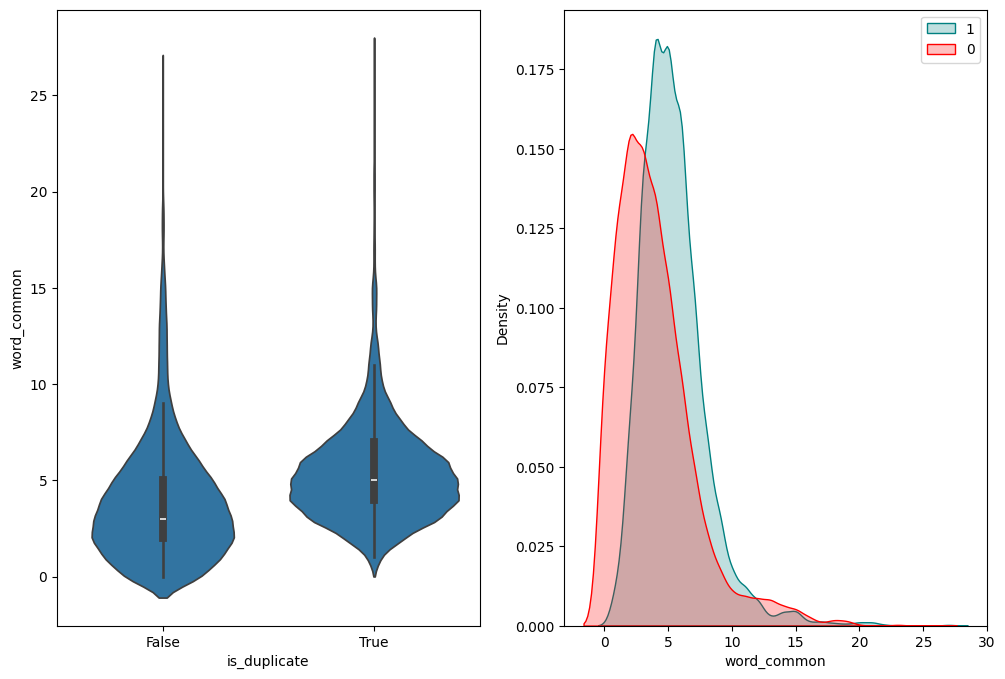

In [31]:
plt.figure(figsize = (12, 8))

plt.subplot(1, 2, 1)
sns.violinplot(x = "is_duplicate", y = "word_common", data = df)

plt.subplot(1, 2, 2)
sns.kdeplot(df[df['is_duplicate'] == 1]['word_common'], label = '1', color='teal', fill = True)
sns.kdeplot(df[df['is_duplicate'] == 0]['word_common'], label = '0', color='red', fill = True)
plt.legend()
plt.show()

Both of the plots presented in the analysis suggest that there is significant overlap between the distributions of the word_Common feature in similar and non-similar questions. This means that the word_Common feature alone may not be a strong enough indicator to determine whether two questions are similar or not. It is important to take into account other features as well when building models for identifying duplicate questions, in order to achieve a high level of accuracy.

In [32]:
#Pre-processing of data
def preprocess_data(text):
    # conver to string
    text = str(text)
    # lowercase
    text = text.lower()
    # remove contractions
    text = contractions.fix(text)
    # remove hashtags
    text = re.sub(r'#(\w+)','',text)
    # remove special characters
    text = re.sub(r'[^\w ]+','',text)
    # remove links if any
    text = re.sub(r'https?://\S+|www\.\S+','',text)
    # remove non-ascii
    text = ''.join(word for word in text if ord(word) < 128)
    # remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))
    # remove digits
    text = re.sub(r'[\d]+','',text)
    # remove single letters
    text = ' '.join(word for word in text.split() if len(word) > 1)
    # remove multiple spaces
    text = ' '.join(text.split())

    return text

In [34]:
df_pretrain = new_df_train.copy() # Create a copy of the original dataframe
df_pretrain.loc[:,"text_question1"] = df_pretrain["text_question1"].apply(preprocess_data)
df_pretrain.loc[:,"text_question2"] = df_pretrain["text_question2"].apply(preprocess_data)
df_pretrain.head()

,text_question1,text_question2,is_duplicate
0,how do gain healthy weight without eating junk,what are the healthy ways of gaining weight an...,True
1,what is unusual or different about the food an...,what is unusual or different about the food an...,False
2,how can make music player with sensor in android,how can make music player for android,False
3,how much can you charge for website,how much can charge for website,True
4,how can treat swollen clitoris,how do you treat swollen tongue,False


In [35]:
df_pretest = new_df_test.copy() # Create a copy of the original dataframe
df_pretest.loc[:,"text_question1"] = df_pretest["text_question1"].apply(preprocess_data)
df_pretest.loc[:,"text_question2"] = df_pretest["text_question2"].apply(preprocess_data)
df_pretest.head()

,text_question1,text_question2,is_duplicate
0,was it appropriate for meryl streep to use her...,should meryl streep be using her position to a...,True
1,have forgot the screen unlock pin code of my h...,how do unlock my htc,False
2,what book do you want to read,how do you choose what books you read,False
3,how do you know what is true and what is not,how do we know what is true and what is not,True
4,have seen bald men treated equally as others i...,what do indian guys think of beautiful bald girls,False


In [37]:
# Fit Tfidf Vectorizer of train & test dataset

tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(df_pretrain['text_question1']+' '+df_pretrain['text_question2'])

#no. of feature
test_tfidf = tfidf.transform(df_pretest['text_question1']+' '+df_pretest['text_question2'])

train_tfidf.shape,test_tfidf.shape

((283003, 82815), (121287, 82815))

In [21]:

labels = df_pretrain['is_duplicate']
model_xgb = xgb.XGBClassifier()
model_xgb.fit(train_tfidf,labels)

predictions = model_xgb.predict(test_tfidf)
predictions = list(predictions)

print('Accuracy score:',accuracy_score(df_pretest['is_duplicate'],predictions))

Accuracy score: 0.7507729600039575


In [38]:
df_pretrain

,text_question1,text_question2,is_duplicate
0,how do gain healthy weight without eating junk,what are the healthy ways of gaining weight an...,True
1,what is unusual or different about the food an...,what is unusual or different about the food an...,False
2,how can make music player with sensor in android,how can make music player for android,False
3,how much can you charge for website,how much can charge for website,True
4,how can treat swollen clitoris,how do you treat swollen tongue,False
...,...,...,...
282998,what is best way for preparing civil services ...,can graduate crack civil services exam,True
282999,how do improve my english speaking,how can enhance my english language,True
283000,would you beat man up if he talked and flirted...,would you beat woman up if she talks to your b...,False
283001,what is the difference between media and liter...,what are some of the main differences between ...,False


In [40]:
df_pretrain['T1_tokens'] = df_pretrain['text_question1'].apply(word_tokenize)
df_pretrain['T2_tokens'] = df_pretrain['text_question2'].apply(word_tokenize)

word_tokenized_sentences = df_pretrain['T1_tokens'].tolist() + df_pretrain['T2_tokens'].tolist()

print(word_tokenized_sentences[2222])


train_model_word = word2vec.Word2Vec(sentences=word_tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4,seed=42)

print(train_model_word.wv['told'])

['this', 'guy', 'told', 'me', 'he', 'cheated', 'on', 'his', 'girlfriend', 'of', 'years', 'broke', 'up', 'few', 'months', 'ago', 'and', 'got', 'back', 'recently', 'and', 'cheated', 'again', 'what', 'is', 'wrong', 'with', 'him']
[-0.26468718 -1.180239    2.1991522  -0.22983432 -0.5662666  -0.58144635
  0.43283457 -0.08739287  0.55922776  1.6833241  -1.2576606  -0.6983906
  1.1616923   0.4242856  -0.3238301  -0.37772757 -1.9168807  -1.2009548
 -0.9515019   0.5676939  -1.8595349   0.4948844   0.0961898   0.60630876
 -0.6549736  -2.7860053  -0.6641706  -0.28160816 -0.2815715  -0.24271151
 -0.44294566  0.5057704   1.289655    1.7969124   0.4515467   2.6789637
 -2.4195151  -0.84640384  1.2106884   0.13052413 -3.0433502   0.7075656
  1.3104306  -1.8939949  -1.5522605  -0.16915795 -0.34756142  1.8960605
 -0.46692327  0.65937734 -1.5523089   0.06904104 -0.02636044  0.7549448
 -0.34946692 -1.9269204  -1.004256    0.61883223  0.98952734  0.90377
 -1.6580455  -2.5573628  -0.56761634  0.47873446  0.

In [41]:
df_pretest['T1_tokens'] = df_pretest['text_question1'].apply(word_tokenize)
df_pretest['T2_tokens'] = df_pretest['text_question2'].apply(word_tokenize)

word_tokenized_sentences = df_pretest['T1_tokens'].tolist() + df_pretest['T2_tokens'].tolist()

print(word_tokenized_sentences[2222])
#rename word tokenize

feature_size = 256
context_size = 5
min_word = 1
epochs = 50
random_seed = 42

# Train Word2Vec model


test_model_word = word2vec.Word2Vec(sentences=word_tokenized_sentences, vector_size=feature_size,
                                   window=context_size,
                                   min_count=min_word,
                                   epochs=epochs,
                                   seed=random_seed)

print(test_model_word.wv['told'])

['which', 'fdaapproved', 'supplements', 'can', 'help', 'me', 'lose', 'weight', 'and', 'build', 'muscles']
[-6.6282547e-01  8.0855435e-01  2.5015324e-01 -1.8814695e+00
  8.6119789e-01  2.0651879e-02  1.3746151e+00  5.0543559e-01
 -2.0705807e+00 -1.0710002e+00  1.5103798e+00 -2.4295500e-01
  1.1439692e+00  1.8570498e-01  4.0048820e-01  2.4571604e-01
 -1.5931650e+00  1.0393404e+00 -8.1591719e-01 -3.1522284e+00
 -6.3822460e-01  1.6921544e+00 -1.2246628e+00  2.3758861e-01
  1.8575267e+00  1.7470615e+00  1.0539044e+00 -6.2361246e-01
  9.8644835e-01  5.4865394e-02  1.2781605e+00 -9.2763948e-01
  3.4407544e+00  6.2873727e-01 -2.2871623e+00 -7.2532541e-01
  1.7120166e-01 -6.9537252e-02 -6.9362327e-02  2.8406020e-02
  4.0997475e-01  3.3500224e-02  1.6467497e+00 -2.6642752e-01
 -1.3864042e+00  7.7186900e-01  2.2741387e+00  2.8871329e+00
 -8.1795490e-01 -4.7396901e-01 -1.0276517e+00  6.1258346e-01
  7.4080634e-01 -2.1675587e+00 -8.4621626e-01 -6.6373932e-01
  2.7409771e-01 -2.7055052e-01  1.143749

In [42]:
#word2vec model

#Tokenization of train dataset using bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenized_sentencestrain = []
#rename bert tokenization
for example in df_pretrain['text_question1']:
    tokenized_sentencestrain.append(tokenizer.tokenize(example))

for example in df_pretrain['text_question2']:
    tokenized_sentencestrain.append(tokenizer.tokenize(example))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [43]:
#Tokenization of test dataset
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokenized_sentences = []

for example in df_pretest['text_question1']:
    tokenized_sentences.append(tokenizer.tokenize(example))

for example in df_pretest['text_question2']:
    tokenized_sentences.append(tokenizer.tokenize(example))

In [44]:
print(tokenized_sentencestrain[2222])

['this', 'guy', 'told', 'me', 'he', 'cheated', 'on', 'his', 'girlfriend', 'of', 'years', 'broke', 'up', 'few', 'months', 'ago', 'and', 'got', 'back', 'recently', 'and', 'cheated', 'again', 'what', 'is', 'wrong', 'with', 'him']


In [45]:
print(tokenized_sentences[2222])

['which', 'fda', '##app', '##roved', 'supplements', 'can', 'help', 'me', 'lose', 'weight', 'and', 'build', 'muscles']


In [46]:
np.set_printoptions(suppress=True)


In [47]:
# Define parameters for Word2Vec model
feature_size = 256
context_size = 5
min_word = 1
epochs = 50
random_seed = 42

# Train Word2Vec model
word_vec_model = word2vec.Word2Vec(tokenized_sentencestrain,
                                   vector_size=feature_size,
                                   window=context_size,
                                   min_count=min_word,
                                   epochs=epochs,
                                   seed=random_seed)
#keep the parameters same for both tokenization methods
print(word_vec_model.wv['told'])
#tokenizer of bert and traditional tokenizer comparison - research question

[-1.0872034  -0.3486233  -2.2861924   0.5947483  -0.3710989  -1.8651034
 -2.580971   -1.0636468   0.12308092 -0.06925086 -0.33057734  1.2513472
  0.00244004  1.9150395   0.85452247  0.6038014   0.90017617  1.5490127
  1.8014622   0.8211352  -0.29207215 -2.0623243  -3.1987648   0.8491619
 -0.28741428 -0.04630682 -2.3519146   3.407966    1.2578505   2.0120282
 -1.2525175  -0.81027454 -0.87562764  1.9796791  -1.434109   -3.2216647
 -0.7628126   1.5548676   0.6600044  -0.61390597  0.17761396  0.39361757
 -0.4839897  -2.324782   -1.3329035  -2.6665928  -2.0699854   0.21707048
 -0.63681734  0.8366521   1.3724887  -0.9566273   3.4888966   0.35683978
  1.3225965   0.7280865   0.06060288  2.0763574  -0.48117033 -1.5705729
 -0.13375142  2.8704462  -3.1896183   0.67168766 -0.7491049  -1.6902021
 -1.5863649   0.827981    0.62890303  0.63376063 -0.36170813 -3.4711797
  1.5174558  -2.1073072   0.9529209  -0.51741385 -2.0602639   0.65686834
 -1.0472176  -2.4036748  -1.1409111  -2.224716   -0.87572   

In [48]:
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, BertConfig
from sentence_transformers import SentenceTransformer
import torch


# Get word embeddings and vocabulary
word_embeddings = word_vec_model.wv
word_vocab = list(word_embeddings.key_to_index.keys())
word_embedding_dim = word_embeddings.vector_size

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
config = BertConfig.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, config=config)

# Create a new tokenizer with the desired vocabulary size
new_tokenizer = BertTokenizer.from_pretrained(model_name)
new_tokenizer.add_tokens(word_vocab)  # Add Word2Vec vocabulary to the tokenizer

# Update the model with the new tokenizer
model.resize_token_embeddings(len(new_tokenizer))

# Initialize a Sentence Transformers model
sentence_transformer_model = SentenceTransformer(modules=[model])

# Save the Sentence Transformers model
#sentence_transformer_model.save("path/to/sentence_transformer/model")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'sentence_transformers.SentenceTransformer.SentenceTransformer'>

next step:- use representation to represent those sentences. Tokenize the sentences

In [34]:
from keras.preprocessing.text import Tokenizer

# Initialize the Tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the tokenized text
tokenizer.fit_on_texts(tokenized_sentencestrain)

# Convert the tokenized text to sequences of integers
sequences = tokenizer.texts_to_sequences(tokenized_sentences)

# Padding sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, padding='post')

# Converting the padded sequences into a NumPy array
tokenized_array = np.array(padded_sequences)

# Checking the shape of the tokenized array
print("Shape of tokenized array:", tokenized_array.shape)

Shape of tokenized array: (242574, 223)
